<a href="https://colab.research.google.com/github/sanyamjain789523/personalProjects/blob/main/BRI_Initiatives_Hypothesis_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
# nltk.download('stopwords')
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
# from sklearn.model_selection import train_test_split
# from keras.utils.np_utils import to_categorical
# from keras.callbacks import EarlyStopping
# from keras.layers import Dropout
import re
from nltk.corpus import stopwords
import json
from nltk import word_tokenize
# STOPWORDS = set(stopwords.words('english'))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


1b) The usage of Zheng He will be greater in countries that he travelled to in his voyages and that these voyages will be framed as peaceful, promoting trade, in nature.

-> Filter out the most popular articles mentioning Zheng He in the respective country's news articles.

-> These observations then shall be verified with actual facts.

2a) Zheng He's usage is particularly useful in countries that are weary of Chinese investment. Therefore, we expect to see more mentions of Zheng He in countries where BRI initiatives are being challenged or have failed.

-> This hypothesis shall be collectively analyzed along with the previous one i.e after filtering out most popular countries where he's been mentioned, wherein it would be verified by the respective facts that I'll be researching countries where BRI initiatives are being challenged or have failed

1a) Zheng He is being reframed as a 'peaceful emissary' to promote the BRI investment and trade goals with neighbouring countries.

-> This is a bit tricky, what i can say for this hypothesis prior to starting the project is:

-> I shall train a text analytics model that would analyze the news articles of the neighboring countries because i don't think he would be mentioned as 'peaceful emissary' in news articles, hence we'll have to analyze the article as a whole whether it's nature was positive or negative

In [ ]:
df = pd.read_csv("Article_Zhenghe.csv")

In [ ]:
df.columns

Index(['Title', 'Title (translation)', 'Media type', 'Date Published',
       'Country/Region', 'Text', 'Language', 'Translation (formula)',
       'Translation (values)', 'Source', 'URL', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14'],
      dtype='object')

In [ ]:
# df = df[['Title (translation)', 'Media type', 'Country/Region', 'Translation (values)']]

In [ ]:
df.head()

,Title,Title (translation),Media type,Date Published,Country/Region,Text,Language,Translation (formula),Translation (values),Source,URL,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
0,中马将合作拍摄大型电视连续剧《郑和》,"Malaysia will team up large-scale TV series ""Z...",Newspaper,2019-11-1,Malaysia,中马合拍历史大剧《郑和》新闻发布会1日在马来西亚吉隆坡举行。马来西亚新濠天影有限公司与中国国...,Chinese,Malaysia co-production major historical drama ...,Malaysia co-production major historical drama ...,Xinhua agency,http://www.xinhuanet.com/2019-11/01/c_11251833...,NaN,NaN,NaN,NaN
1,“2019国际郑和论坛”在马来西亚举行,"""Zheng 2019 International Forum"" held in Malaysia",Newspaper,2019-11-15,Malaysia,“2019国际郑和论坛”14日至15日在马来西亚古城马六甲举行。本次论坛由马来西亚旅游和文化...,Chinese,"""2019 International Forum on Zheng He"" was hel...","""2019 International Forum on Zheng He"" was hel...",Xinhua agency,http://www.xinhuanet.com/2019-11/15/c_11252384...,NaN,NaN,NaN,NaN
2,晋宁郑和·世界航海邮票展览馆： 方寸之间遨游世界航海史,Jinning Zheng-world sailing Stamp Exhibition: ...,Newspaper,2019-7-10,China,人们常把邮票称之为“国家名片”，本国值得骄傲的古今人物、事物都寓于邮票的方寸之间。在郑和故里...,Chinese,"People often put a stamp called ""national card...","People often put a stamp called a ""national ca...",Xinhua agency,http://m.xinhuanet.com/yn/2019-07/10/c_1382144...,NaN,NaN,NaN,NaN
3,带着“一带一路”的独家记忆 “熊猫小记者”郑和队返程！,"With ""along the way"" exclusive memory ""Panda s...",Picture News,2019-8-22,Maldives,8月22日，成都市广播电视台“熊猫小记者”郑和队圆满完成了9天的行程，带着满满的感悟与记忆返...,Chinese,"August 22, Chengdu Radio and Television ""Panda...","August 22, Chengdu Radio and Television ""Panda...",Xinhua agency,http://www.sc.xinhuanet.com/content/2019-08/22...,NaN,NaN,NaN,NaN
4,从郑和下西洋到今天，中国经历了怎样的变化？,"From Zheng He to this day, China has experienc...",Newspaper,2019-10-27,China,15世纪初叶，郑和率领当时世界上最强大的船队，完成了7次下西洋的壮举。中国的造船技术和航海技...,Chinese,"Early in the 15th century, Zheng He led the wo...","Early in the 15th century, Zheng He led the wo...",Xinhua agency,http://www.qstheory.cn/laigao/ycjx/2019-10/27/...,NaN,NaN,NaN,NaN


In [ ]:
# df['Translation (values)'].str.len().reset_index().sort_values(ascending = False, by = "Translation (values)").head(20)["Translation (values)"].to_list()

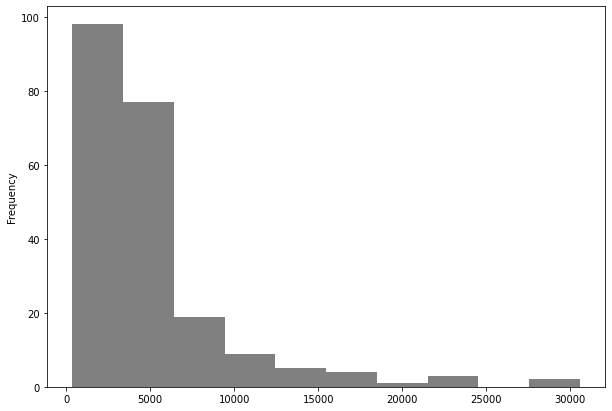

In [ ]:
length_train = df['Translation (values)'].str.len().plot.hist(color = 'grey', figsize = (10, 7))
plt.savefig("length distribution")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Title                  219 non-null    object 
 1   Title (translation)    218 non-null    object 
 2   Media type             218 non-null    object 
 3   Date Published         218 non-null    object 
 4   Country/Region         218 non-null    object 
 5   Text                   218 non-null    object 
 6   Language               218 non-null    object 
 7   Translation (formula)  218 non-null    object 
 8   Translation (values)   218 non-null    object 
 9   Source                 218 non-null    object 
 10  URL                    218 non-null    object 
 11  Unnamed: 11            0 non-null      float64
 12  Unnamed: 12            0 non-null      float64
 13  Unnamed: 13            0 non-null      float64
 14  Unnamed: 14            1 non-null      float64
dtypes: flo

In [ ]:
df = df.fillna("")

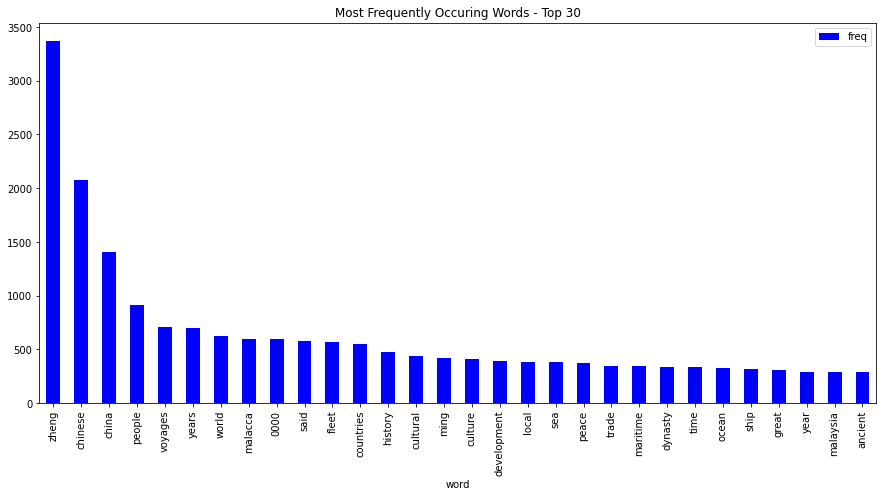

In [ ]:
# Distribution to depict the frequency of most common words

from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df["Translation (values)"])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")
plt.savefig("Most Frequently Occuring Words - Top 30")

In [ ]:
def filterZheng(x):
  if "zheng" in x.lower().split() or "zhenghe" in x.lower().split():
    return "present"
  return "not present"

In [ ]:
df["zhengFilter"] = df["Translation (values)"].apply(lambda x: filterZheng(x))

In [ ]:
df.head()

,Title,Title (translation),Media type,Date Published,Country/Region,Text,Language,Translation (formula),Translation (values),Source,URL,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,zhengFilter
0,中马将合作拍摄大型电视连续剧《郑和》,"Malaysia will team up large-scale TV series ""Z...",Newspaper,2019-11-1,Malaysia,中马合拍历史大剧《郑和》新闻发布会1日在马来西亚吉隆坡举行。马来西亚新濠天影有限公司与中国国...,Chinese,Malaysia co-production major historical drama ...,Malaysia co-production major historical drama ...,Xinhua agency,http://www.xinhuanet.com/2019-11/01/c_11251833...,,,,,present
1,“2019国际郑和论坛”在马来西亚举行,"""Zheng 2019 International Forum"" held in Malaysia",Newspaper,2019-11-15,Malaysia,“2019国际郑和论坛”14日至15日在马来西亚古城马六甲举行。本次论坛由马来西亚旅游和文化...,Chinese,"""2019 International Forum on Zheng He"" was hel...","""2019 International Forum on Zheng He"" was hel...",Xinhua agency,http://www.xinhuanet.com/2019-11/15/c_11252384...,,,,,present
2,晋宁郑和·世界航海邮票展览馆： 方寸之间遨游世界航海史,Jinning Zheng-world sailing Stamp Exhibition: ...,Newspaper,2019-7-10,China,人们常把邮票称之为“国家名片”，本国值得骄傲的古今人物、事物都寓于邮票的方寸之间。在郑和故里...,Chinese,"People often put a stamp called ""national card...","People often put a stamp called a ""national ca...",Xinhua agency,http://m.xinhuanet.com/yn/2019-07/10/c_1382144...,,,,,present
3,带着“一带一路”的独家记忆 “熊猫小记者”郑和队返程！,"With ""along the way"" exclusive memory ""Panda s...",Picture News,2019-8-22,Maldives,8月22日，成都市广播电视台“熊猫小记者”郑和队圆满完成了9天的行程，带着满满的感悟与记忆返...,Chinese,"August 22, Chengdu Radio and Television ""Panda...","August 22, Chengdu Radio and Television ""Panda...",Xinhua agency,http://www.sc.xinhuanet.com/content/2019-08/22...,,,,,present
4,从郑和下西洋到今天，中国经历了怎样的变化？,"From Zheng He to this day, China has experienc...",Newspaper,2019-10-27,China,15世纪初叶，郑和率领当时世界上最强大的船队，完成了7次下西洋的壮举。中国的造船技术和航海技...,Chinese,"Early in the 15th century, Zheng He led the wo...","Early in the 15th century, Zheng He led the wo...",Xinhua agency,http://www.qstheory.cn/laigao/ycjx/2019-10/27/...,,,,,present


In [ ]:
df.zhengFilter.value_counts()

present        214
not present     12
Name: zhengFilter, dtype: int64

In [ ]:
# loading the model
model = load_model("model.h5")

In [ ]:
# loading the tokenizer

import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
def predictingForDataset(s):
  l = []
  s = re.sub('[^A-Za-z]'," ",s)
  s = s.strip()
  s = s.replace(" +"," ")

  l.append(s)
  # print(l)
  text = l
  MAX_SEQUENCE_LENGTH= 200
  seq = tokenizer.texts_to_sequences(text)
  # print(seq)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  # print(pred)
  # print(Y)
  # labels = dummies.columns
  labels = [0, 4]
  # print("labels: ",labels)
  # print(pred, labels[np.argmax(pred)])

  if labels[np.argmax(pred)] == 4:
    return "positive"
    # print("sentiment: positive")
  else:
    return "negative"

In [ ]:
df["predictions"] = df["Translation (values)"].apply(lambda x: predictingForDataset(x))

In [ ]:
df.head()

,Title,Title (translation),Media type,Date Published,Country/Region,Text,Language,Translation (formula),Translation (values),Source,URL,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,zhengFilter,predictions
0,中马将合作拍摄大型电视连续剧《郑和》,"Malaysia will team up large-scale TV series ""Z...",Newspaper,2019-11-1,Malaysia,中马合拍历史大剧《郑和》新闻发布会1日在马来西亚吉隆坡举行。马来西亚新濠天影有限公司与中国国...,Chinese,Malaysia co-production major historical drama ...,Malaysia co-production major historical drama ...,Xinhua agency,http://www.xinhuanet.com/2019-11/01/c_11251833...,,,,,present,positive
1,“2019国际郑和论坛”在马来西亚举行,"""Zheng 2019 International Forum"" held in Malaysia",Newspaper,2019-11-15,Malaysia,“2019国际郑和论坛”14日至15日在马来西亚古城马六甲举行。本次论坛由马来西亚旅游和文化...,Chinese,"""2019 International Forum on Zheng He"" was hel...","""2019 International Forum on Zheng He"" was hel...",Xinhua agency,http://www.xinhuanet.com/2019-11/15/c_11252384...,,,,,present,positive
2,晋宁郑和·世界航海邮票展览馆： 方寸之间遨游世界航海史,Jinning Zheng-world sailing Stamp Exhibition: ...,Newspaper,2019-7-10,China,人们常把邮票称之为“国家名片”，本国值得骄傲的古今人物、事物都寓于邮票的方寸之间。在郑和故里...,Chinese,"People often put a stamp called ""national card...","People often put a stamp called a ""national ca...",Xinhua agency,http://m.xinhuanet.com/yn/2019-07/10/c_1382144...,,,,,present,positive
3,带着“一带一路”的独家记忆 “熊猫小记者”郑和队返程！,"With ""along the way"" exclusive memory ""Panda s...",Picture News,2019-8-22,Maldives,8月22日，成都市广播电视台“熊猫小记者”郑和队圆满完成了9天的行程，带着满满的感悟与记忆返...,Chinese,"August 22, Chengdu Radio and Television ""Panda...","August 22, Chengdu Radio and Television ""Panda...",Xinhua agency,http://www.sc.xinhuanet.com/content/2019-08/22...,,,,,present,negative
4,从郑和下西洋到今天，中国经历了怎样的变化？,"From Zheng He to this day, China has experienc...",Newspaper,2019-10-27,China,15世纪初叶，郑和率领当时世界上最强大的船队，完成了7次下西洋的壮举。中国的造船技术和航海技...,Chinese,"Early in the 15th century, Zheng He led the wo...","Early in the 15th century, Zheng He led the wo...",Xinhua agency,http://www.qstheory.cn/laigao/ycjx/2019-10/27/...,,,,,present,negative


In [ ]:
df.to_csv("dfPredictions.csv", index=False)

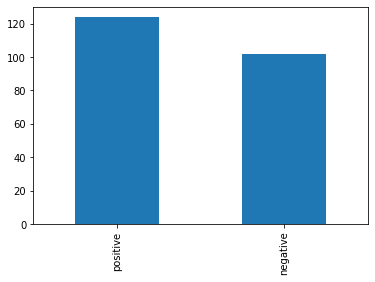

In [ ]:
df.predictions.value_counts().plot.bar()
plt.savefig("predictions counts")

In [ ]:
negScore = []
posScore = []
predLabel = []
dft = df[df.zhengFilter == "present"]
import re
for ind in range(len(dft)):
  l = []
  # print(ind)
  s = dft.iloc[ind,3]
  s = re.sub('[^A-Za-z]'," ",s)
  s = s.strip()
  s = s.replace(" +"," ")

  l.append(s)
  # print(l)
  text = l
  MAX_SEQUENCE_LENGTH= 200
  seq = tokenizer.texts_to_sequences(text)
  # print(seq)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  # print(pred)
  negScore.append(pred[0][0])
  posScore.append(pred[0][1])
  # print(Y)
  # labels = dummies.columns
  labels = [0, 4]
  # print("labels: ",labels)
  # print(pred, labels[np.argmax(pred)])

  if labels[np.argmax(pred)] == 4:
    predLabel.append("positive")
    # print("sentiment: positive")
  else:
    predLabel.append("negative")
    # print("sentiment: negative")
  # print("="*30)

In [ ]:
dfSents = pd.DataFrame({
    "positive confidnence Score":posScore,
    "negative confidnence Score":negScore,
    "Sentiment":predLabel,
})

In [ ]:
dfSents.Sentiment.value_counts()

positive    116
negative     98
Name: Sentiment, dtype: int64

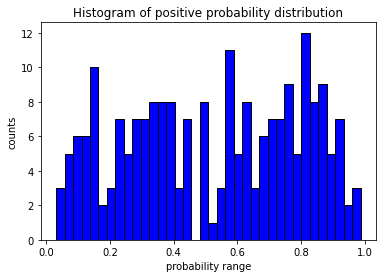

In [ ]:

plt.hist(dfSents["positive confidnence Score"], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

plt.title('Histogram of positive probability distribution')
plt.xlabel('probability range')
plt.ylabel('counts')
plt.savefig("positive probability distribution")

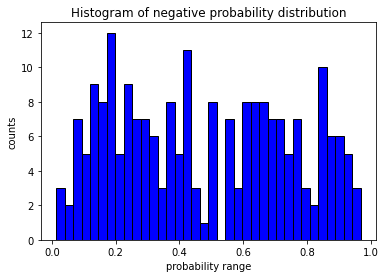

In [ ]:

plt.hist(dfSents["negative confidnence Score"], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

plt.title('Histogram of negative probability distribution')
plt.xlabel('probability range')
plt.ylabel('counts')
plt.savefig("negative probability distribution")

In [ ]:
dfSents.describe()

,positive confidnence Score,negative confidnence Score
count,214.000000,214.000000
mean,0.523056,0.476944
std,0.269460,0.269460
min,0.031403,0.013424
25%,0.296616,0.238965
50%,0.559239,0.440761
75%,0.761035,0.703384
max,0.986576,0.968597


In [ ]:
# keyword part
keywords = ['economy','investments','money']

def keywordMapping(x, keywords = keywords):
  c = 0
  for word in x.split():
    if word in keywords:
      c += 1
  return c

In [ ]:
dfWithScore = df.copy()
dfWithScore["scoreKeys"] = df["Translation (values)"].apply(lambda x: keywordMapping(x))

In [ ]:
dfWithScore.describe()

,scoreKeys
count,226.000000
mean,0.190265
std,0.584308
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,5.000000


In [ ]:
dfGroupedCountriesHypothesisOne = df[df.zhengFilter == "present"].groupby("Country/Region").count()

In [ ]:
dfTopTenCountries = dfGroupedCountriesHypothesisOne.sort_values("Media type", ascending= False)
dfTopTenCountries = dfTopTenCountries["Media type"].reset_index()
# print(dfTopTenCountries.columns)
dfTopTenCountries.columns = ["Country","MentionFrequency"]
# dfTopTenCountries = dfTopTenCountries.reset_index()
dfTopTenCountries

,Country,MentionFrequency
0,China,64
1,Malaysia,49
2,Kenya,23
3,Indonesia,20
4,Sri Lanka,9
5,Thailand,7
6,Somalia,7
7,Singapore,5
8,Taiwan,3
9,India,3


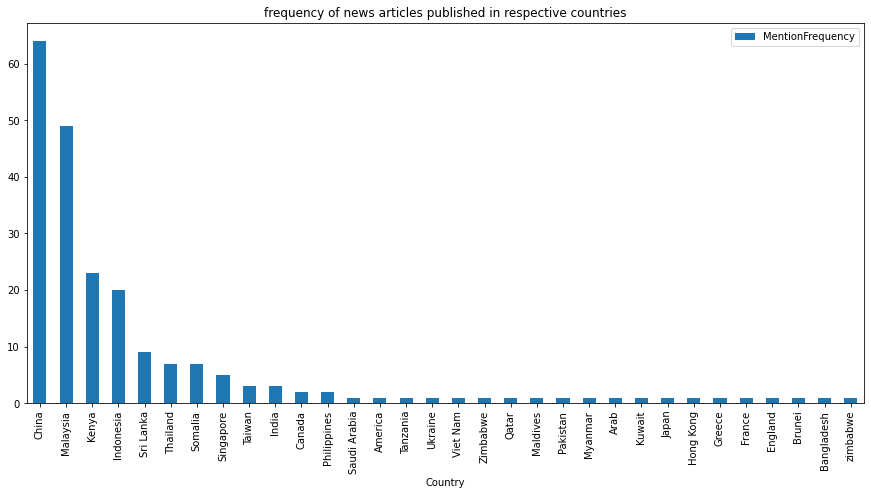

In [ ]:
dfTopTenCountries.plot(x='Country', y='MentionFrequency', kind='bar', figsize=(15, 7))
plt.title("frequency of news articles published in respective countries")
plt.savefig("frequency of news articles published in respective countries")

### Conclusion: Most of the articles mentioning Zheng He are with particular countries clearly depicting targeted promotion.

In [ ]:
dfTopTenCountries.describe()

,MentionFrequency
count,32.000000
mean,6.687500
std,14.193223
min,1.000000
25%,1.000000
50%,1.000000
75%,3.500000
max,64.000000


In [ ]:
popularCountriesWithZheng = dfGroupedCountriesHypothesisOne.sort_values("Media type", ascending= False).head(10).index.to_list()

In [ ]:
popularCountriesWithZheng

['China',
 'Malaysia',
 'Kenya',
 'Indonesia',
 'Sri Lanka',
 'Thailand',
 'Somalia',
 'Singapore',
 'Taiwan',
 'India']

Countries resisting BRI investments:

source: https://www.cnbc.com/2019/01/18/countries-are-reducing-belt-and-road-investments-over-financing-fears.html

Myanmar
Sierra Leone
Bangladesh

Countries at high risks by "debt trap" as per studies:

source: https://www.csis.org/npfp/its-debt-trap-managing-china-imf-cooperation-across-belt-and-road


Djibouti, Kyrgyzstan, Laos, the Maldives, Mongolia, Montenegro, Pakistan, and Tajikistan.
Malaysia cancelled two chinese funded projects.


Protests in Kenya against BRI initiatives:
source: https://www.orfonline.org/research/chinas-belt-and-road-initiative-implications-in-africa/


BRI project reluctance amonst indonesian people:
source: https://theasiadialogue.com/2019/10/04/belt-and-road-initiative-in-indonesia-and-relations-with-china/

### Hypothesis 2a has been verified, the data tells us the most popular countries where articles mentioning ZhengHe have been published.

### These are the countries where anti BRI sentiments exists as per the media sources mentioned above.

source: https://www.britannica.com/biography/Zheng-He

According to the article above.

Zheng He visited the states of Southeast Asia, the coast of India, the Persian Gulf, the Red Sea, and the east coast of Africa. Zheng died in Calicut in the spring of 1433, and the fleet returned to China that summer.

These geographic locations are the present day :

Malaysia

Kenya

Indonesia

Sri Lanka

Thailand

Somalia

Singapore

Taiwan

India

### Hence the hypothesis 1b has been proved successfully, the sentiment analysis for the same has been done at the end of the notebook

In [ ]:
s = "Afghanistan, Bhutan, India, Kazakhstan, North Korea, Kyrgyzstan, Laos, Mongolia, Myanmar, Nepal, Pakistan, Russia, Tajikistan, Viet nam"
s = s.lower()
sL = s.split(", ")

In [ ]:
sL

['afghanistan',
 'bhutan',
 'india',
 'kazakhstan',
 'north korea',
 'kyrgyzstan',
 'laos',
 'mongolia',
 'myanmar',
 'nepal',
 'pakistan',
 'russia',
 'tajikistan',
 'viet nam']

In [ ]:
df["neighbouringCountries"] = df["Country/Region"].apply(lambda x: "neighbouring" if x.lower() in sL else "not neighbouring")

In [ ]:
df.head()

,Title (translation),Media type,Country/Region,Translation (values),zhengFilter,neighbouringCountries
0,"Malaysia will team up large-scale TV series ""Z...",Newspaper,Malaysia,Malaysia co-production major historical drama ...,present,not neighbouring
1,"""Zheng 2019 International Forum"" held in Malaysia",Newspaper,Malaysia,"""2019 International Forum on Zheng He"" was hel...",present,not neighbouring
2,Jinning Zheng-world sailing Stamp Exhibition: ...,Newspaper,China,"People often put a stamp called a ""national ca...",present,not neighbouring
3,"With ""along the way"" exclusive memory ""Panda s...",Picture News,Maldives,"August 22, Chengdu Radio and Television ""Panda...",present,not neighbouring
4,"From Zheng He to this day, China has experienc...",Newspaper,China,"Early in the 15th century, Zheng He led the wo...",present,not neighbouring


In [ ]:
df["peacefulMention"] = df["Translation (values)"].apply(lambda x: "peacefull mentioned" if "peaceful" in x.lower().split() else "peacefull not mentioned")

In [ ]:
df.head()

,Title (translation),Media type,Country/Region,Translation (values),zhengFilter,neighbouringCountries,peacefulMention
0,"Malaysia will team up large-scale TV series ""Z...",Newspaper,Malaysia,Malaysia co-production major historical drama ...,present,not neighbouring,peacefull not mentioned
1,"""Zheng 2019 International Forum"" held in Malaysia",Newspaper,Malaysia,"""2019 International Forum on Zheng He"" was hel...",present,not neighbouring,peacefull not mentioned
2,Jinning Zheng-world sailing Stamp Exhibition: ...,Newspaper,China,"People often put a stamp called a ""national ca...",present,not neighbouring,peacefull not mentioned
3,"With ""along the way"" exclusive memory ""Panda s...",Picture News,Maldives,"August 22, Chengdu Radio and Television ""Panda...",present,not neighbouring,peacefull not mentioned
4,"From Zheng He to this day, China has experienc...",Newspaper,China,"Early in the 15th century, Zheng He led the wo...",present,not neighbouring,peacefull not mentioned


In [ ]:
df.peacefulMention.value_counts()

peacefull not mentioned    179
peacefull mentioned         47
Name: peacefulMention, dtype: int64

In [ ]:
dfNeighbouringCountries = df[df.neighbouringCountries == "neighbouring"]

In [ ]:
dfNeighbouringCountries

,Title (translation),Media type,Country/Region,Translation (values),zhengFilter,neighbouringCountries,peacefulMention
36,"In India, looking for Zheng He era",Newspaper,India,"""Squawks"", a burst of creaking, five in operat...",present,neighbouring,peacefull not mentioned
60,Chinese Embassy in Myanmar was held to commemo...,Newspaper,Myanmar,"According to the Chinese Foreign Ministry, Jan...",present,neighbouring,peacefull not mentioned
79,India: Zheng He's fleet of large trade bilater...,Newspaper,India,"During Zheng He's seven voyages, India, Kerala...",present,neighbouring,peacefull not mentioned
81,South Indian peninsula pursue Zheng,Newspaper,India,Zheng He's first voyage destination is Calicut...,present,neighbouring,peacefull not mentioned
138,Ho Chi Minh City write rapidly: Zheng funeral ...,Newspaper,Viet Nam,"""Curse of the motorcycle."" This is the first i...",present,neighbouring,peacefull not mentioned
169,Historical Review of China and Pakistan,Newspaper,Pakistan,China and Pakistan will always be mutual neigh...,present,neighbouring,peacefull not mentioned


In [ ]:
dfNeighbouringCountries.peacefulMention.value_counts()

peacefull not mentioned    6
Name: peacefulMention, dtype: int64

### Peaceful hasn't been explicitly mentioned in the news articles of the neighbouring countries. Hence the hypothesis 1a is rejected

In [ ]:
# loading the model
model = load_model("model.h5")

In [ ]:
# loading the tokenizer

import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
dfNeighbouringCountries.head(1)

,Title (translation),Media type,Country/Region,Translation (values),zhengFilter,neighbouringCountries,peacefulMention
36,"In India, looking for Zheng He era",Newspaper,India,"""Squawks"", a burst of creaking, five in operat...",present,neighbouring,peacefull not mentioned


In [ ]:
dfNeighbouringCountries

,Title (translation),Media type,Country/Region,Translation (values),zhengFilter,neighbouringCountries,peacefulMention
36,"In India, looking for Zheng He era",Newspaper,India,"""Squawks"", a burst of creaking, five in operat...",present,neighbouring,peacefull not mentioned
60,Chinese Embassy in Myanmar was held to commemo...,Newspaper,Myanmar,"According to the Chinese Foreign Ministry, Jan...",present,neighbouring,peacefull not mentioned
79,India: Zheng He's fleet of large trade bilater...,Newspaper,India,"During Zheng He's seven voyages, India, Kerala...",present,neighbouring,peacefull not mentioned
81,South Indian peninsula pursue Zheng,Newspaper,India,Zheng He's first voyage destination is Calicut...,present,neighbouring,peacefull not mentioned
138,Ho Chi Minh City write rapidly: Zheng funeral ...,Newspaper,Viet Nam,"""Curse of the motorcycle."" This is the first i...",present,neighbouring,peacefull not mentioned
169,Historical Review of China and Pakistan,Newspaper,Pakistan,China and Pakistan will always be mutual neigh...,present,neighbouring,peacefull not mentioned


In [ ]:
negScore = []
posScore = []
predLabel = []
import re
for ind in range(len(dfNeighbouringCountries)):
  l = []
  # print(ind)
  s = dfNeighbouringCountries.iloc[ind,3]
  s = re.sub('[^A-Za-z]'," ",s)
  s = s.strip()
  s = s.replace(" +"," ")

  l.append(s)
  # print(l)
  text = l
  MAX_SEQUENCE_LENGTH= 200
  seq = tokenizer.texts_to_sequences(text)
  # print(seq)
  padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
  pred = model.predict(padded)
  print(pred)
  negScore.append(pred[0][0])
  posScore.append(pred[0][1])
  # print(Y)
  # labels = dummies.columns
  labels = [0, 4]
  # print("labels: ",labels)
  # print(pred, labels[np.argmax(pred)])

  if labels[np.argmax(pred)] == 4:
    predLabel.append("positive")
    print("sentiment: positive")
  else:
    predLabel.append("negative")
    print("sentiment: negative")
  print("="*30)

[[0.86319995 0.13680007]]
sentiment: negative
[[0.12932196 0.870678  ]]
sentiment: positive
[[0.55266863 0.4473313 ]]
sentiment: negative
[[0.55299175 0.44700828]]
sentiment: negative
[[0.436465 0.563535]]
sentiment: positive
[[0.5701449 0.4298551]]
sentiment: negative


In [ ]:
pd.DataFrame({
    "positive confidnence Score":posScore,
    "negative confidnence Score":negScore,
    "Sentiment":predLabel,
})

,positive confidnence Score,negative confidnence Score,Sentiment
0,0.136800,0.863200,negative
1,0.870678,0.129322,positive
2,0.447331,0.552669,negative
3,0.447008,0.552992,negative
4,0.563535,0.436465,positive
5,0.429855,0.570145,negative


### Hence hypothesis 1a has been rejected completely